In [88]:
from cloudvolume import CloudVolume, Skeleton
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from skimage import io 
from brainlit.map_neurons.map_neurons import (
    DiffeomorphismAction,
    transform_geometricgraph,
    compute_derivs,
    CloudReg_Transform,
)
from brainlit.algorithms.trace_analysis.fit_spline import (
    GeometricGraph,
    compute_parameterization,
    CubicHermiteChain,
)
from brainlit.utils.Neuron_trace import NeuronTrace
from copy import deepcopy
from tqdm import tqdm
from scipy.interpolate import splev, splprep
from brainlit.BrainLine.util import json_to_points
import json
from matplotlib.colors import ListedColormap
from scipy.ndimage import distance_transform_edt, binary_dilation


## Create data

In [ ]:
vol = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_100um/average_100um")
im_og = np.array(vol[:,:,:])

In [ ]:
v = np.arange(im_og.shape[0])
h = np.arange(im_og.shape[1])
d = np.arange(im_og.shape[2])

image_interp = RegularGridInterpolator((v,h,d), im_og, bounds_error=False, fill_value=0)

plt.imshow(im_og[:,:,72])
print(im_og.shape)

In [ ]:
# x is vertical component, y is horizontal
def deformation(v, h):
    y_disp = np.exp(-1*h/20)*np.exp(-1*(v-66)**2/1000)*20
    return y_disp

v_mat, h_mat = np.meshgrid(np.arange(0,132,10), np.arange(0,80,15))
v_flat = np.reshape(v_mat, (-1,1))
h_flat = np.reshape(h_mat, (-1,1))
y_displacements = deformation(v_flat, h_flat)
y_displacements = np.reshape(y_displacements, v_mat.shape)

plt.imshow(im_og[:,:,72], cmap='gray')
plt.quiver(h_mat, v_mat, y_displacements, 0*y_displacements, scale = 1, scale_units='x', facecolor='red')

In [ ]:
v_mat, h_mat, d_mat = np.meshgrid(v, h, d)
v_mat = np.swapaxes(v_mat, 0,1)
h_mat = np.swapaxes(h_mat, 0,1)
d_mat = np.swapaxes(d_mat, 0,1)
print(v_mat.shape)
v_flat = np.reshape(v_mat, (-1))
h_flat = np.reshape(h_mat, (-1))
d_flat = np.reshape(d_mat, (-1))

h_displacements = deformation(v_flat, h_flat)
new_h = h_flat - h_displacements

In [ ]:
points = np.stack([v_flat, new_h, d_flat], axis=1)
new_im_flat = image_interp(points)
new_im = np.reshape(new_im_flat,v_mat.shape)
new_im = new_im.astype('uint16')
plt.imshow(new_im[:,:,72], cmap='gray')

In [ ]:
for name, data in zip(["og", "new"], [im_og, new_im]):
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=vol.voxel_offset,  # x,y,z offset in voxels from the origin
        # mesh            = 'mesh',
        # Pick a convenient size for your underlying chunk representation
        # Powers of two are recommended, doesn't need to cover image exactly
        chunk_size=vol.chunk_size,  # units are voxels
        volume_size=vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    local_vol = CloudVolume(f"precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/{name}/", info=info, compress=False)
    local_vol.commit_info()
    local_vol[:,:,:] = data


## Serve

python cors_webserver.py -d "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/" -p 9010

precomputed://http://127.0.0.1:9010/atlas_to_target_10

## Register

`python -m cloudreg.scripts.registration -input_s3_path precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/new/ --output_s3_path precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_100um/average_100um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_100um/annotation_100um_2017 --atlas_orientation PIR -orientation PIR --rotation 0 0 0 --translation 0 0 0 --fixed_scale 1 -log_s3_path precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/log/ --missing_data_correction False --grid_correction False --bias_correction False --regularization 5000.0 --iterations 3000 --registration_resolution 100`

python -m cloudreg.scripts.transform_points --target_viz_link "https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=aB9pLBQXd6Liyg" --atlas_viz_link "https://ara.viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=HvyNDGaPsd1wyg" --affine_path "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/new__registration/downloop_1_A.mat" --velocity_path "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/new__registration/downloop_1_v.mat" --transformation_direction "atlas"

## Write target points

In [77]:
local_skels_path = "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/target_skels/"
vol_atlas = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/new/")
info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="segmentation",
    data_type="uint16",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=vol_atlas.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=vol_atlas.voxel_offset,  # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size=vol_atlas.chunk_size,  # units are voxels
    volume_size=vol_atlas.volume_size,  # e.g. a cubic millimeter dataset
    skeletons="skeletons"
)
vol_atlas_skels = CloudVolume(local_skels_path, info=info, compress=False)
vol_atlas_skels.commit_info()
vol_atlas_skels.skeleton.meta.commit_info()

# remove vertex type attribute because it is a uint8 and incompatible with neuroglancer
info_path = f"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/target_skels/skeletons/info"
with open(info_path) as f:
    data = json.load(f)
    for i, attr in enumerate(data["vertex_attributes"]):
        if attr["id"] == "vertex_types":
            data["vertex_attributes"].pop(i)
            break

with open(info_path, "w") as f:
    json.dump(data, f)


In [78]:
target_pts_ng = np.array([[67,38,123],[167,21.5,123]])
target_pts = target_pts_ng * 50 * 1000
vol_atlas_skels = CloudVolume(local_skels_path, compress=False)
skel = Skeleton(
            segid=0, vertices=target_pts, edges=[[i - 1, i] for i in range(1, len(target_pts))], space="voxel"
        )
vol_atlas_skels.skeleton.upload(skel)



## Transform points to atlas space

In [109]:
velocity_path = "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/new__registration/downloop_1_v.mat"
affine_path = "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/new__registration/downloop_1_A.mat"

ct = CloudReg_Transform(velocity_path, affine_path)

vol = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/new")
shp = np.array(vol.shape)
res = np.array(vol.resolution) / 1000
origin = (shp[:3] - 1) * res / 2


integrating velocity field: 100%|██████████| 10/10 [00:25<00:00,  2.58s/it]


In [101]:

#coords_ng = json_to_points(url = "https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=jgKyiSBVTWJWJQ")['points']
coords_ng = target_pts_ng
coords_skel = np.multiply(coords_ng, 1000 * res)

coords_centered = coords_skel / 1000 - origin
coords_affine = ct.apply_affine(coords_centered)
coords_transform = ct.evaluate(coords_affine)
coords_ng_atlas = np.divide(coords_transform, 10) + (np.array([1320, 800, 1140])-1) / 2
coords_ng_atlas

array([[339.04483784, 179.11989593, 619.13806114],
       [838.00974954,  52.08827137, 620.15455135]])

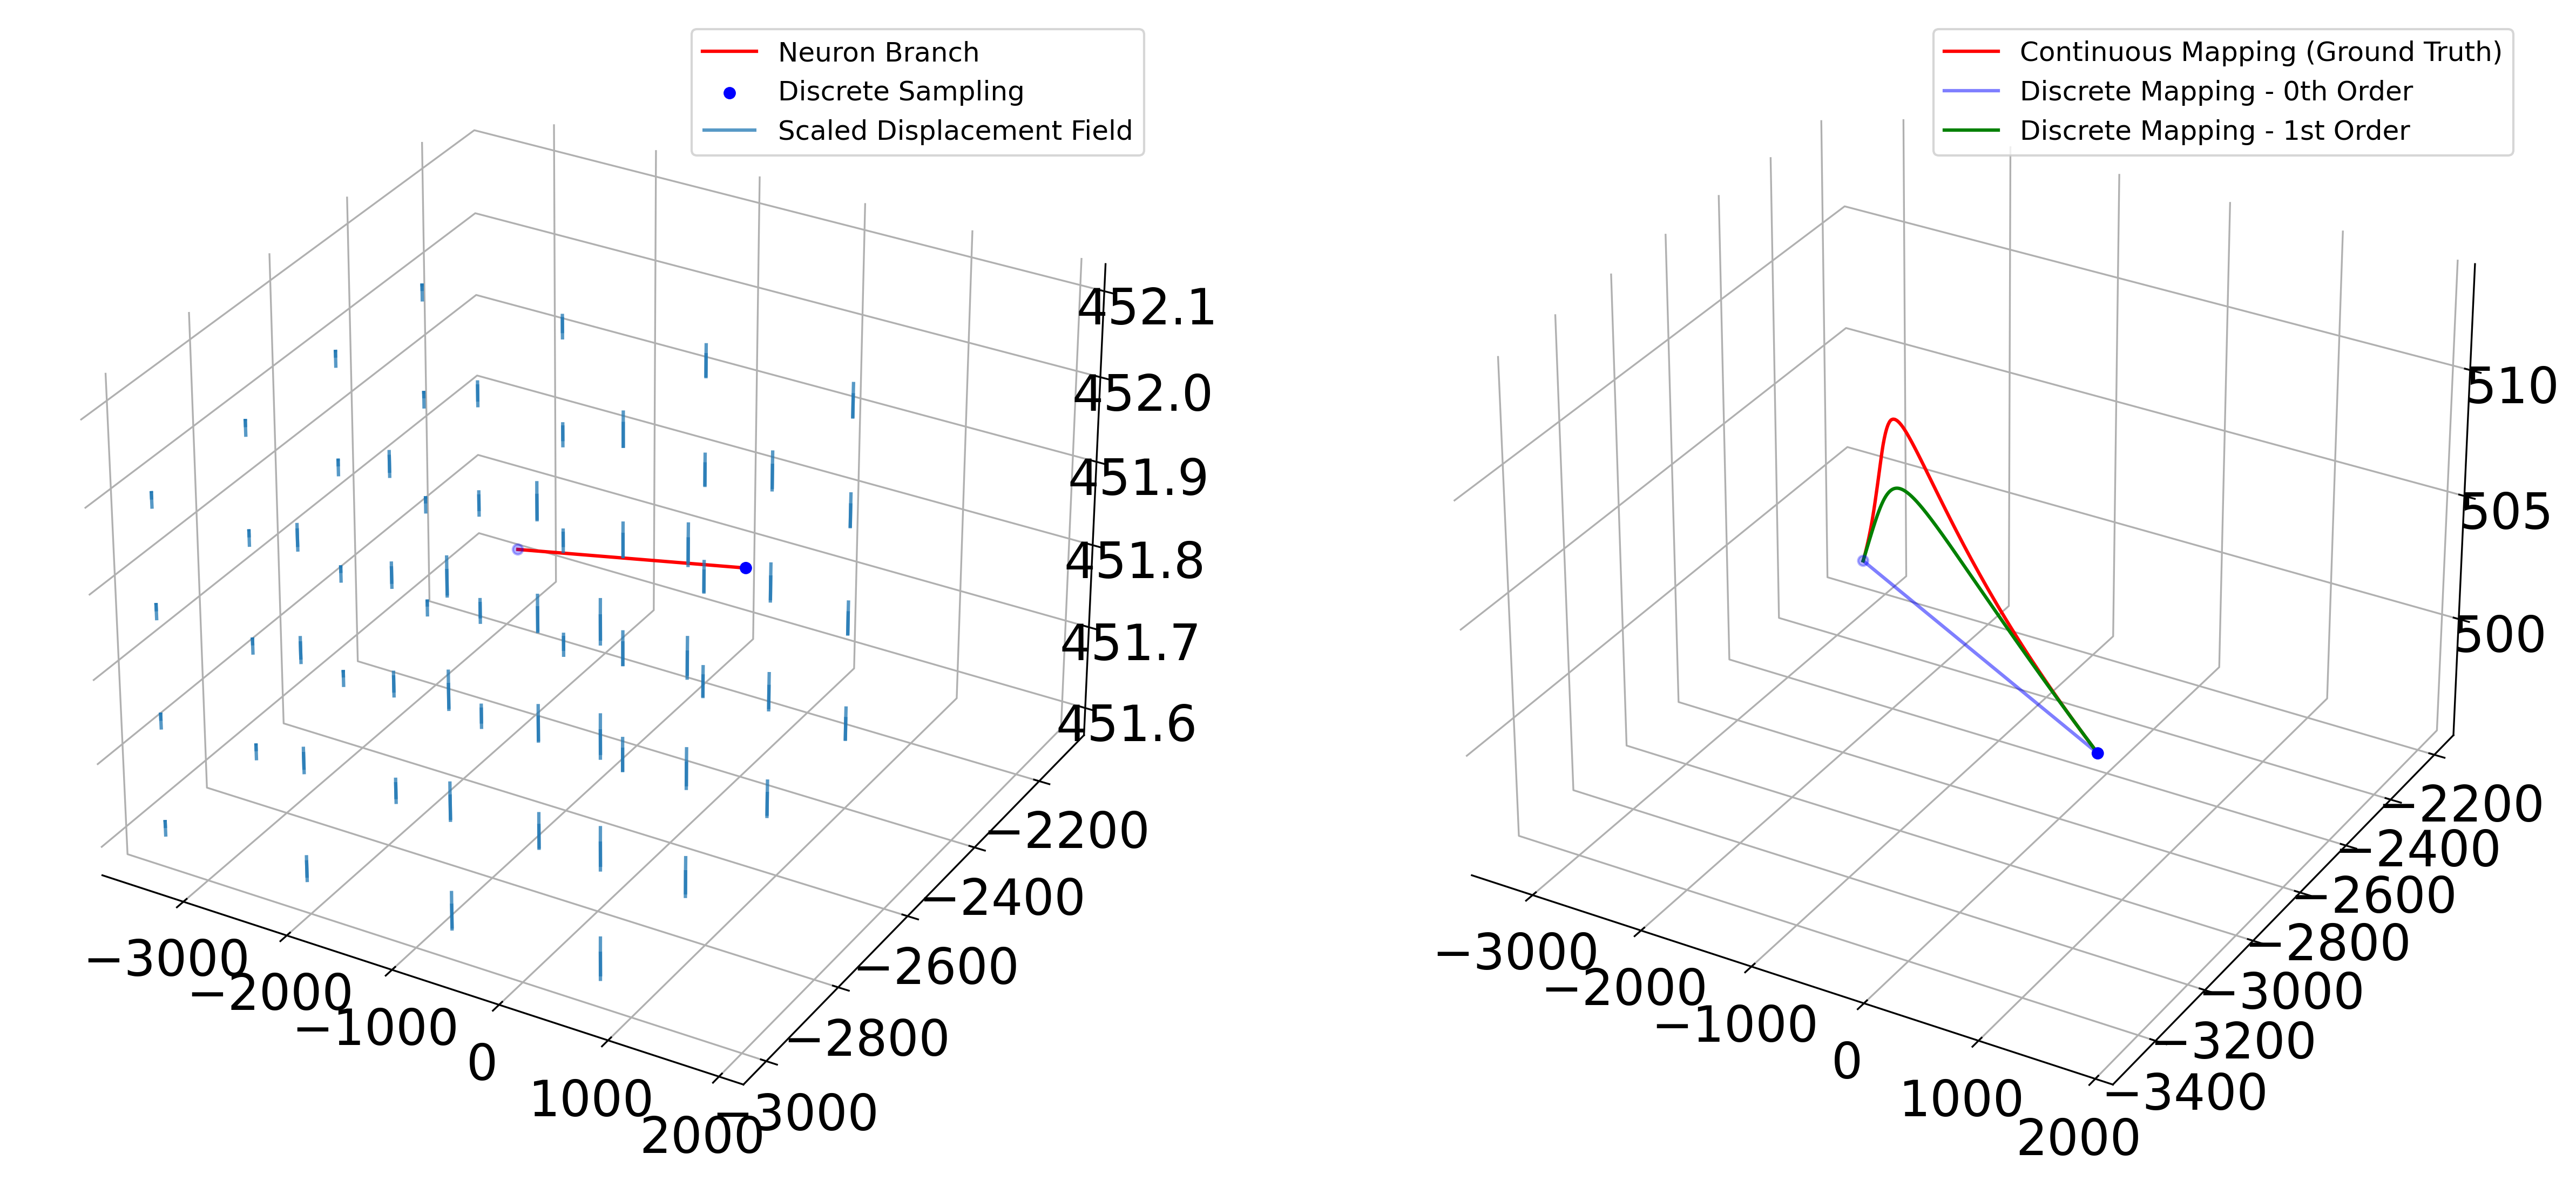

In [103]:
coords = coords_centered

# apply affine transform
coords = ct.apply_affine(coords)

G = GeometricGraph()
for id, coord in enumerate(coords):
    G.add_node(id, loc=coord)
    if id > 0:
        G.add_edge(id-1,id)

spline_tree = G.fit_spline_tree_invariant()
# Target space
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = fig.add_subplot(1, 2, 1, projection="3d")

G_transformed = deepcopy(G)
G_transformed = transform_geometricgraph(G_transformed, ct, deriv_method="two-sided")
soma = np.array(G.nodes[G.root]["loc"])
spline_tree = G.spline_tree

spline = spline_tree.nodes[0]["spline"]
u = spline[1]
tck = spline[0]

# trace points only
pts = splev(u, tck)
label = "Neuron Branch"
ax.plot(pts[0], pts[1], pts[2], linestyle="-", label=label, color="red")
ax.scatter(
    pts[0], pts[1], pts[2], linestyle="-", label="Discrete Sampling", color="blue"
)
derivs = splev(u, tck, der=1)

# Plot displacement field
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()
xs = np.arange(xmin, xmax, (xmax - xmin) / 4)
ys = np.arange(ymin, ymax, (ymax - ymin) / 4)
zs = np.arange(zmin, zmax, (zmax - zmin) / 4)

og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
og_coords = np.array(
    [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
).T
new_coords = ct.evaluate(og_coords)

displacements = new_coords - og_coords
ax.quiver(
    og_coords[:, 0],
    og_coords[:, 1],
    og_coords[:, 2],
    displacements[:, 0],
    displacements[:, 1],
    displacements[:, 2],
    length=.0005,
    label="Scaled Displacement Field",
    alpha=0.75,
)  # length

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.legend(fontsize=12)

ax = fig.add_subplot(1, 2, 2, projection="3d")

node = spline_tree.nodes[0]["spline"]
u = spline[1]
tck = spline[0]
og_target = splev(u, tck)
og_target = np.stack(og_target, axis=1)

# dense line points
tck_line, u_line = splprep(og_target.T, k=1, s=0)
u_line = np.arange(u_line[0], u_line[-1] + 0.01, 0.01)
gt_target = splev(u_line, tck_line)
gt_target = np.stack(gt_target, axis=1)
gt_atlas = ct.evaluate(gt_target)
label = "Continuous Mapping (Ground Truth)"
ax.plot(
    gt_atlas[:, 0],
    gt_atlas[:, 1],
    gt_atlas[:, 2],
    linestyle="-",
    color="red",
    label=label,
)

# Transformed points
og_atlas = ct.evaluate(og_target)
label = "Discrete Mapping - 0th Order"
ax.plot(
    og_atlas[:, 0],
    og_atlas[:, 1],
    og_atlas[:, 2],
    linestyle="-",
    label=label,
    color="blue",
    alpha=0.5,
)
ax.scatter(og_atlas[:, 0], og_atlas[:, 1], og_atlas[:, 2], color="blue")
derivs = splev(u, tck, der=1)
derivs = np.stack(derivs, axis=1)
og_derivs_atlas = ct.D(og_target, derivs)

# act on derivatives
soma = np.array(G_transformed.nodes[G_transformed.root]["loc"])
spline_tree = G_transformed.spline_tree

spline = spline_tree.nodes[0]["spline"]
u = spline[1]
u = np.arange(u[0], u[-1] + 0.01, 0.01)
chspline = spline[0]
fo_atlas = chspline(u)

label = "Discrete Mapping - 1st Order"
ax.plot(fo_atlas[:, 0], fo_atlas[:, 1], fo_atlas[:, 2], linestyle="-", label=label, color="green")

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.grid(True)
ax.legend(fontsize=12)

plt.show()

In [82]:
local_skels_path = "precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/atlas_skels/"
vol_atlas = CloudVolume("precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
info = CloudVolume.create_new_info(
    num_channels=1,
    layer_type="segmentation",
    data_type="uint16",  # Channel images might be 'uint8'
    encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution=vol_atlas.resolution,  # Voxel scaling, units are in nanometers
    voxel_offset=vol_atlas.voxel_offset,  # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size=vol_atlas.chunk_size,  # units are voxels
    volume_size=vol_atlas.volume_size,  # e.g. a cubic millimeter dataset
    skeletons="skeletons"
)
vol_atlas_skels = CloudVolume(local_skels_path, info=info, compress=False)
vol_atlas_skels.commit_info()
vol_atlas_skels.skeleton.meta.commit_info()

# remove vertex type attribute because it is a uint8 and incompatible with neuroglancer
info_path = f"/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/atlas_skels/skeletons/info"
with open(info_path) as f:
    data = json.load(f)
    for i, attr in enumerate(data["vertex_attributes"]):
        if attr["id"] == "vertex_types":
            data["vertex_attributes"].pop(i)
            break

with open(info_path, "w") as f:
    json.dump(data, f)


In [84]:
for id, pts in enumerate([gt_atlas, og_atlas, fo_atlas]):
    if pts.shape[0] > 10000:
        xs = list(np.arange(1, pts.shape[0]-1, 1000))
        xs = [0] + xs + [pts.shape[0]-1]
        pts = pts[xs,:]
    pts2 = np.divide(pts, 10) + (np.array([1320, 800, 1140])-1) / 2
    pts2 = pts2 * vol_atlas.resolution
    vol_atlas_skels = CloudVolume(local_skels_path, compress=False)
    skel = Skeleton(
                segid=id, vertices=pts2, edges=[[i - 1, i] for i in range(1, len(pts2))], space="voxel"
            )
    vol_atlas_skels.skeleton.upload(skel)

## Create Jacobian figure

In [156]:
def get_transformed_line(a, b, ct):
    ts = np.arange(0, 1.01, 0.01)
    line = np.zeros((len(ts), len(a)))
    for i, t in enumerate(ts):
        line[i, :] = a + t * (b - a)
    new_line = ct.evaluate(line)
    return new_line


def get_displacements(xs, ys, zs, ct):
    og_coords = np.meshgrid(xs, ys, zs, indexing="ij")
    og_coords = np.array(
        [og_coords[0].flatten(), og_coords[1].flatten(), og_coords[2].flatten()]
    ).T
    print(f"shp: {og_coords.shape}")
    print(og_coords[5,:])
    coords_affine = ct.apply_affine(og_coords)
    new_coords = ct.evaluate(coords_affine)
    print(new_coords[5,:])
    diff = new_coords - og_coords


    return og_coords, diff


def get_border(im, border_id=0):
    if (im < 0).any():
        raise ValueError(f"Input image cannot have negative values")
    if border_id != 0:
        im[im == 0] = -1
        im[im == border_id] = 0
    edt = distance_transform_edt(im)
    edt[edt != 1] = 0
    return edt

In [237]:
slice_ng = 125

og_coords = ct.og_coords

rlmin = np.amin(og_coords[0])
rlmax = np.amax(og_coords[0])
apmin = np.amin(og_coords[1])
apmax = np.amax(og_coords[1])
dvmin = np.amin(og_coords[2])
dvmax = np.amax(og_coords[2])

vol_im = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/new")
slice = np.squeeze(vol_im[:,:,slice_ng])

shp = np.array(vol_im.shape)
res = np.array(vol_im.resolution) / 1000
origin = (shp[:3]-1) * res / 2


slice_ct = slice_ng * 50 - origin[2] #convert to microns then center
print(slice_ct)
#ara = io.imread("/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif")

Downloading: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

575.0


In [244]:
apmin

-7550.0

100%|██████████| 529/529 [00:04<00:00, 107.90it/s]


shp: (45, 3)
[-5662.5 -2475.    575. ]
[-5615.48295793 -2447.36763325   577.31185372]


Downloading: 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


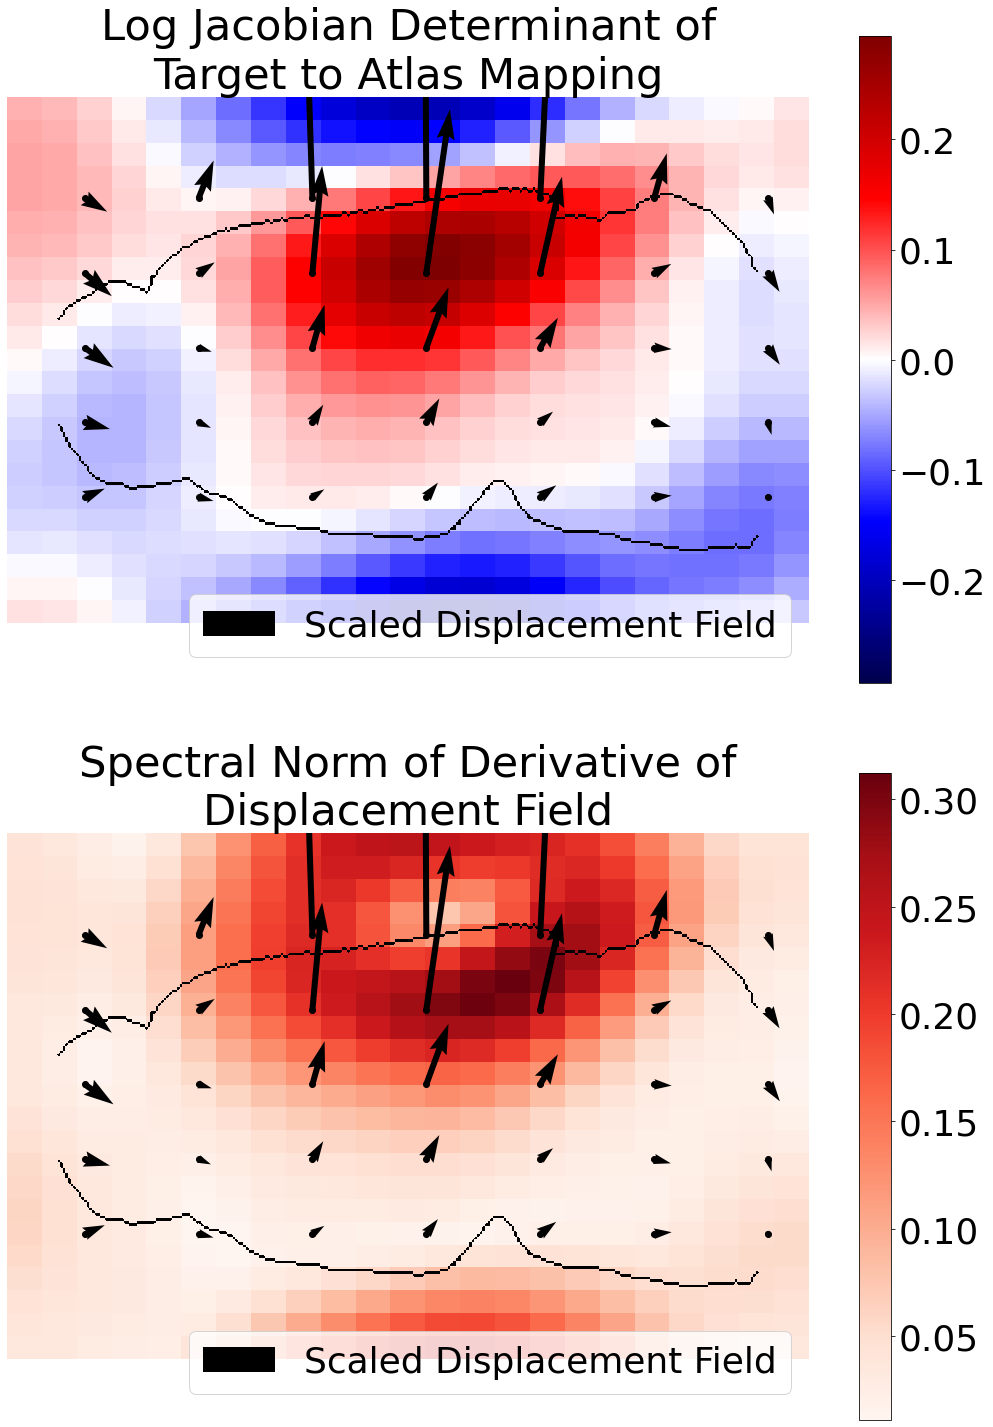

In [282]:
plt.rcParams.update({"font.size": 36})
fig, axes = plt.subplots(2,1, figsize=(15, 21))

# # Determinant jacobians

zs = np.array([slice_ct])
apgap = (apmax - apmin) / 25
xs = np.arange(apmin+apgap, apmax-apgap, apgap)
dvgap = (dvmax - dvmin) / 25
ys = np.arange(dvmin+dvgap, dvmax-dvgap, dvgap)

Xs, Ys, Zs = np.meshgrid(xs, ys, zs, indexing='ij')
XYZs = np.reshape(np.stack((Xs, Ys, Zs), axis=-1), newshape=(-1, 3))
XYZs = ct.apply_affine(XYZs)
normJmIs = []
detJs = []

for coord in tqdm(XYZs):
    J = ct.Jacobian(coord)
    JmI = J - np.eye(3)
    normJmIs.append(np.linalg.norm(JmI))
    detJs.append(np.log(np.linalg.det(J)))

normJmIs = np.array(normJmIs)
normJmIs = np.reshape(normJmIs, newshape=Xs.shape)
detJs = np.array(detJs)
detJs = np.reshape(detJs, newshape=Xs.shape)



max_abs = np.amax(np.abs(normJmIs))
plt_ldjs = axes[1].imshow(
    np.squeeze(normJmIs).T,
    extent=(np.amin(Xs), np.amax(Xs), np.amin(Ys), np.amax(Ys)),
    cmap="Reds",
)
axes[1].axis("off")
fig.colorbar(plt_ldjs, ax=axes[1])


max_abs = np.amax(np.abs(detJs))
plt_ldjs = axes[0].imshow(
    np.squeeze(detJs).T,
    extent=(np.amin(Xs), np.amax(Xs), np.amin(Ys), np.amax(Ys)),
    cmap="seismic",
    vmin = -max_abs,
    vmax = max_abs
)
axes[0].axis("off")
fig.colorbar(plt_ldjs, ax=axes[0])

# Displacement

zs = np.array([slice_ct])
apgap = (apmax - apmin) / 8
xs = np.arange(apmin, apmax+1, apgap)
dvgap = (dvmax - dvmin) / 8
ys = np.arange(dvmin+2*dvgap, dvmax-dvgap, dvgap)
og_coords, diff = get_displacements(xs, ys, zs, ct)

axes[0].scatter(og_coords[:, 0], -og_coords[:, 1], c="black")
axes[1].scatter(og_coords[:, 0], -og_coords[:, 1], c="black")


axes[0].quiver(
    og_coords[:, 0],
    -og_coords[:, 1],
    diff[:, 0],
    -1*diff[:, 1],
    label="Scaled Displacement Field",
    color="black",
    # scale_units='xy',
    # scale=1
)
axes[1].quiver(
    og_coords[:, 0],
    -og_coords[:, 1],
    diff[:, 0],
    -1*diff[:, 1],
    label="Scaled Displacement Field",
    color="black",
    # scale_units='xy',
    # scale=1
)

#ax.imshow(slice.T, extent=(-8000, 8000, -5000, 5000))

# # ARA border

# ara_slice = np.squeeze(ara[:, :, x])

vol_a2t = CloudVolume("precomputed://file:///Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/motivation-synthetic/res-50/atlas_to_target")
slice = np.squeeze(vol_a2t[:,:,slice_ng])
border = get_border(slice)
border = border.T
#border = binary_dilation(border, iterations=1)
border_dilated = np.pad(border, 19)

newcolors = np.array([[1, 1, 1, 0], [0, 0, 0, 1]])
cmap_trans_white = ListedColormap(newcolors)
plt_border = axes[0].imshow(border_dilated, extent=(np.amin(Xs), np.amax(Xs), np.amin(Ys), np.amax(Ys)), cmap=cmap_trans_white)
plt_border = axes[1].imshow(border_dilated, extent=(np.amin(Xs), np.amax(Xs), np.amin(Ys), np.amax(Ys)), cmap=cmap_trans_white)

axes[0].legend(loc="lower right", bbox_to_anchor=(1, -0.1))
axes[1].legend(loc="lower right", bbox_to_anchor=(1, -0.1))
axes[0].set_title("Log Jacobian Determinant of\nTarget to Atlas Mapping")
axes[1].set_title("Spectral Norm of Derivative of\nDisplacement Field")
fig.tight_layout()